# BrandPref MVP Evaluation
- vetting MVP:
    - framework to help team evaluate segmentation hypothesis
    - basic question: "can these set of dimensions effectively segment customers"
- One Year of brand pref data
    - category dresses
    - users who made at least 5 purchase


In [16]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
from time import time
import scipy.stats as stats

# Pretty display for notebooks
%matplotlib inline





## Helper Functions:

In [17]:
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

## New Plot function that splits into 5 at a time

def pca_results2(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''
    
    
    
    # Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Configure the number of dims to show per subplot
	dims_per_plot = dpp = 5

	# Prepare plot with appropriate number of subplots
	# Note: see [1]
	plot_rows = -(-len(dimensions) // dims_per_plot)
	fig, axes = plt.subplots(plot_rows, 1, figsize = (14,8*plot_rows))

	# For each subplot...
	for c, ax in enumerate(axes):

	    # Plot the appropriate components
	    components.iloc[c*dpp:c*dpp+dpp].plot(ax=ax, kind='bar');
	    ax.set_ylabel("Feature Weights")

	    # Configure the xticks
	    # Note: set_xticks is necessary for correct display of partially filled plots
	    ax.set_xticks(range(dpp+1))
	    ax.set_xticklabels(dimensions[c*dpp:c*dpp+dpp], rotation=0)

	    # Display the explained variance ratios
	    # Note: the ha and multialignment kwargs allow centering of (multiline) text
	    for i, ev in enumerate(pca.explained_variance_ratio_[c*dpp:c*dpp+dpp]):
	        ax.text(i, ax.get_ylim()[1] + 0.02, 
	                "Explained Variance\n%.4f" % (ev), 
	                ha='center', multialignment='center')

	# Done
	plt.show()


	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)



def cluster_results(reduced_data, preds, centers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	# Plot transformed sample points 
	ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
	           s = 150, linewidth = 4, color = 'black', marker = 'x');

	# Set plot title
	ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");


def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute

    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax
    



### Load data:


In [18]:

try:
    # data = pd.read_csv("/Users/sshields/Desktop/stuff/Segmentation/sample_users_regions_geog",sep='\t',names = ['indiv_key','product_id','home_category_name','prodtype','brand','sales','num_products','city','state','country','DMA'])
    data = pd.read_csv('dresses_5449_preference_brands_20170417_20180412.csv',sep='\~',names=['user_id','brand','preference_brand'])
    print "Dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"
    

data.head()

/Users/sshields/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


Dataset has 785897 samples with 3 features each.


,user_id,brand,preference_brand
0,3949334,MSK,0.37
1,3949334,RACHEL RACHEL ROY,0.37
2,3949334,BAR III,0.19
3,3949334,TAYLOR,0.19
4,4105144,ALFANI,0.68


## Analysis tasks:
- 1) what behaviours create segment
    - compare cluster means to descriptive statistics
- 2) How many customers are in segment
    - look at results of cluster analysis
- 5) What is our action
    - look at results of cluster analysis and boosting options available
- 7) Create visualization for results
    - notebook should take care of this

## Data Exploration


In [4]:
print "data records:{}".format(data.shape[0])


data records:785897


#### Checking fill rate see if fields useful for analysis:

In [5]:


data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785897 entries, 0 to 785896
Data columns (total 3 columns):
user_id             785897 non-null int64
brand               785897 non-null object
preference_brand    785897 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 18.0+ MB


In [6]:
data.apply(lambda x: float(sum(x.isnull()))/len(x))

user_id             0.0
brand               0.0
preference_brand    0.0
dtype: float64

#### Observation:
- Fields are completely filled.

#### Distinct Value Counts:

In [7]:
print "unique brand: {}".format(data['brand'].nunique())
print "unique user_id: {}".format(data['user_id'].nunique())


unique brand: 125
unique user_id: 190662


#### brand distribution:

In [5]:


ProdCat=data.groupby('brand')['user_id'].nunique().sort_values(ascending=False)
ProdCat.head(n=50)


brand
CALVIN KLEIN                  59980
LAUREN RALPH LAUREN           55559
INC INTERNATIONAL CONCEPTS    51751
STYLE & CO                    43948
BAR III                       34552
ADRIANNA PAPELL               26513
TOMMY HILFIGER                25546
JESSICA HOWARD                24915
MSK                           23591
CHARTER CLUB                  22656
ECI                           21876
ALFANI                        21867
THALIA SODI                   21493
MICHAEL KORS                  20935
NINE WEST                     20587
SL FASHIONS                   20445
NY COLLECTION                 19561
CONNECTED                     19549
MAISON JULES                  15878
VINCE CAMUTO                  15474
XSCAPE                        15122
AMERICAN LIVING               15039
RACHEL RACHEL ROY             14904
BETSY & ADAM                  12320
KAREN SCOTT                   12220
R & M RICHARDS                11352
FREE PEOPLE                   11262
GUESS                 

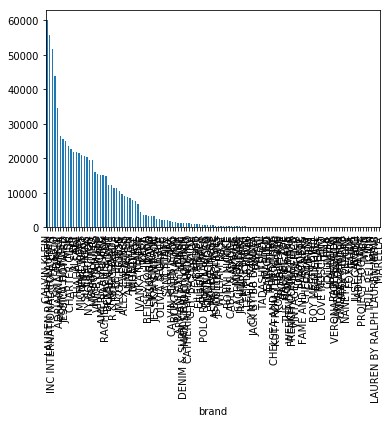

In [9]:
ProdCat.plot(kind='bar')

## Preprocessing:

In [19]:
# Creating dataframe of brand preferences
brandDf=data.pivot_table(values='preference_brand', index='user_id', columns='brand', aggfunc=np.max)
brandDf=brandDf.fillna(0)
brandDf.head()

brand,1.STATE,ADELYN RAE,ADIDAS,ADRIANNA PAPELL,ALEX EVENINGS,ALFANI,AMERICAN LIVING,ANNE KLEIN,ARMANI EXCHANGE,ASTR THE LABEL,...,TRUE RELIGION,TWIIN,UNDER ARMOUR,VERONA COLLECTION,VINCE CAMUTO,VINTAGE AMERICA,WEEKEND MAX MARA,WILLIAM RAST,XSCAPE,YYIGAL
user_id,,,,,,,,,,,,,,,,,,,,,
3949334,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4105144,0.0,0.0,0.0,0.0,0.0,0.68,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4112355,0.0,0.0,0.0,0.0,0.0,0.43,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4174859,0.0,0.0,0.0,0.0,0.0,0.45,0.0,0.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4181196,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### percentage of records that are 0 for brand pref:

In [6]:

brandDf.apply(lambda x: (float(sum(x==0))/len(x))*100)

brand
1.STATE                 98.889658
ADELYN RAE              99.993706
ADIDAS                  99.847898
ADRIANNA PAPELL         86.094240
ALEX EVENINGS           95.187819
ALFANI                  88.531013
AMERICAN LIVING         92.112220
ANNE KLEIN              95.592724
ARMANI EXCHANGE         99.363271
ASTR THE LABEL          99.727791
B MICHAEL               99.977971
BAR III                 81.877878
BARDOT                  99.474463
BCBG                    99.993182
BCBGENERATION           99.269388
BETSEY JOHNSON          98.219362
BETSY & ADAM            93.538303
BOY MEETS GIRL.         99.977447
CABLE & GAUGE           99.837933
CALVIN KLEIN            68.541188
CALVIN KLEIN JEANS      99.219561
CATHERINE MALANDRINO    99.416769
CECE                    98.063589
CHAMPION                99.972202
CHARTER CLUB            88.117192
CHELSEA AND THEODORE    99.941257
CHELSEA SKY             99.971678
COLUMBIA                99.981118
CONNECTED               89.746777
CYNTHIA 

In [7]:

brandFilt=brandDf[brandDf>0]
nonZeroDf=brandFilt.dropna()
print "records with all non-zero pref: {}".format(nonZeroDf.shape[0])


records with all non-zero pref: 0


In [8]:

print "records with any zero pref: {}".format(brandDf[(brandDf.T == 0).any()].shape[0])
print "records with non-zero pref: {}".format(brandDf[(brandDf.T != 0).any()].shape[0])
print "percentage with non-zero pref: {}".format(float(brandDf[(brandDf.T != 0).any()].shape[0])/brandDf.shape[0])

records with any zero pref: 190662
records with non-zero pref: 190662
percentage with non-zero pref: 1.0


## Descriptive Statistics:

In [9]:
# Display a description of the dataset for non-zero values
display(brandDf.describe())

brand,1.STATE,ADELYN RAE,ADIDAS,ADRIANNA PAPELL,ALEX EVENINGS,ALFANI,AMERICAN LIVING,ANNE KLEIN,ARMANI EXCHANGE,ASTR THE LABEL,...,TRUE RELIGION,TWIIN,UNDER ARMOUR,VERONA COLLECTION,VINCE CAMUTO,VINTAGE AMERICA,WEEKEND MAX MARA,WILLIAM RAST,XSCAPE,YYIGAL
count,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,...,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.00000,190662.000000,190662.000000
mean,0.003214,0.000015,0.000481,0.054190,0.016117,0.035189,0.025938,0.013648,0.002002,0.000771,...,0.000002,0.000008,0.000023,0.000061,0.024545,0.000080,0.000143,0.00060,0.026566,0.000237
std,0.034995,0.002009,0.014621,0.165912,0.083215,0.116851,0.105540,0.074166,0.029042,0.016966,...,0.000620,0.001334,0.002447,0.005436,0.097204,0.004459,0.008050,0.01418,0.106829,0.008758
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,0.370000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.180000,0.360000,0.370000,1.000000,1.000000,0.480000,1.000000,1.00000,1.000000,0.790000


### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

In [ ]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(brandDf, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## PCA Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

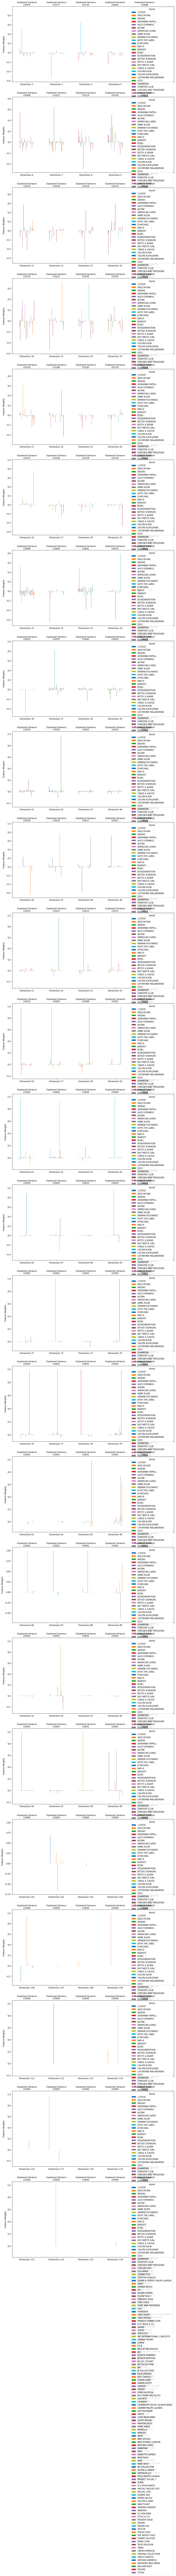

In [6]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
# pca = PCA().fit(good_data)
pca = PCA().fit(brandDf)

# TODO: Transform log_samples using the PCA fit above
# pca_samples = pca.transform(log_samples)

# Generate PCA results plot
# pca_results = pca_results2(good_data, pca)

pca_results = pca_results2(brandDf, pca)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component?*  
**NOTE:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**

Less than 20% of variance is explained by first 2 dimensions.  PCA not very effective.



### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, we will implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [20]:
colList=['Dimensnion_'+str(i+1) for i in range(35)]
colList

['Dimensnion_1',
 'Dimensnion_2',
 'Dimensnion_3',
 'Dimensnion_4',
 'Dimensnion_5',
 'Dimensnion_6',
 'Dimensnion_7',
 'Dimensnion_8',
 'Dimensnion_9',
 'Dimensnion_10',
 'Dimensnion_11',
 'Dimensnion_12',
 'Dimensnion_13',
 'Dimensnion_14',
 'Dimensnion_15',
 'Dimensnion_16',
 'Dimensnion_17',
 'Dimensnion_18',
 'Dimensnion_19',
 'Dimensnion_20',
 'Dimensnion_21',
 'Dimensnion_22',
 'Dimensnion_23',
 'Dimensnion_24',
 'Dimensnion_25',
 'Dimensnion_26',
 'Dimensnion_27',
 'Dimensnion_28',
 'Dimensnion_29',
 'Dimensnion_30',
 'Dimensnion_31',
 'Dimensnion_32',
 'Dimensnion_33',
 'Dimensnion_34',
 'Dimensnion_35']

In [21]:
from sklearn.decomposition import PCA

good_data=brandDf

# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=35).fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data1 = pca.transform(good_data)

# TODO: Transform log_samples using the PCA fit above
# pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data1 = pd.DataFrame(reduced_data1, columns = colList)

## Clustering



### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, we will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [22]:
# testing on local machine

reduced_data = reduced_data1.sample(n=10000)
print reduced_data.shape[0]

10000


## GMM Method

In [11]:
# TODO: Apply your clustering algorithm of choice to the reduced data
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score

# test
#reduced_data = brandDf

for x in range(2,7):
    print("Components: ", x)
    clusterer = GMM(random_state=3, n_components=x).fit(reduced_data) 

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.means_

    print("Centers: ",centers)

    # TODO: Predict the cluster for each transformed sample data point
    #sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, random_state=3)
    print("Silhouette score: ", score)

('Components: ', 2)


/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/util

('Centers: ', array([[-0.03519492, -0.02695407, -0.06275949, -0.06366874, -0.01658928,
        -0.06027013,  0.002975  , -0.01195718,  0.00103884,  0.00628687,
        -0.00759894,  0.00527712,  0.00085226,  0.00884092,  0.00528015,
         0.01002995, -0.00028137, -0.00454528, -0.00454465,  0.00144708,
         0.00651928,  0.00070227,  0.00148495,  0.00622234,  0.00052055,
        -0.00584855,  0.00013877,  0.00524543, -0.00155892, -0.01589659,
        -0.01349927, -0.00134861,  0.03971236,  0.00147425,  0.01662229],
       [ 0.0228028 ,  0.00877625,  0.04487367,  0.02871232,  0.00935079,
         0.03823005, -0.0013801 ,  0.00655893, -0.00250425, -0.0052457 ,
         0.00302296, -0.00131543, -0.00240151, -0.00366135, -0.00480463,
        -0.00653607,  0.0024803 ,  0.00162165,  0.00162862,  0.00144771,
        -0.00116757,  0.00114109, -0.00147305, -0.00082058,  0.00054092,
         0.00225363,  0.00102619, -0.00455122,  0.00067778,  0.01045401,
         0.01080415,  0.00237851, -0

/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/util

('Centers: ', array([[ -8.21562702e-02,  -1.22274193e-02,  -2.53573900e-02,
         -2.14103537e-02,  -6.35452215e-02,  -5.51753288e-02,
          3.47936077e-02,   3.45617793e-02,   4.83769038e-02,
          2.22825613e-02,   2.03570543e-03,  -2.49191822e-03,
          1.62408486e-02,  -1.18569522e-02,  -2.01922662e-02,
         -5.44490270e-02,   1.69153833e-02,  -3.14057444e-02,
          2.51607755e-02,  -2.65650317e-03,   8.21739902e-03,
         -1.37266196e-02,   1.03427625e-02,  -4.92132998e-03,
         -2.62757504e-02,  -4.14533996e-03,  -1.06673383e-02,
          2.13034488e-02,  -9.04390000e-03,  -1.64186859e-02,
         -2.02028431e-02,   1.93375531e-03,   1.19335863e-02,
          3.21047643e-03,   2.95212774e-03],
       [  4.14442528e-02,   1.49217513e-02,   5.63138205e-02,
          4.07021306e-02,   2.17117645e-02,   5.51882403e-02,
         -3.16351836e-03,  -2.32958625e-05,  -6.48677069e-03,
         -8.31612088e-03,   2.23734438e-03,  -2.12994079e-03,
         -5

/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/util

('Centers: ', array([[ 0.01876932, -0.03698956, -0.07944403, -0.09508593,  0.03861543,
        -0.03396447, -0.03208483, -0.06006077, -0.06232955, -0.00627805,
        -0.0105088 ,  0.01223793, -0.01424779,  0.03042679,  0.05333049,
         0.07838303, -0.02354426, -0.00190182, -0.00887014,  0.00879467,
        -0.01132496,  0.01484016,  0.00328254, -0.00463544,  0.036815  ,
        -0.01247681,  0.01776464, -0.02639152,  0.00626384, -0.00509017,
        -0.00760807,  0.00035954,  0.04500503,  0.00641871,  0.02618461],
       [-0.03042604, -0.05272056, -0.05116673, -0.0234949 , -0.11570904,
         0.06726254,  0.13656542,  0.03724736, -0.01547448, -0.00216187,
         0.01386862,  0.05224473, -0.00192014, -0.00767786, -0.04451039,
        -0.0488528 ,  0.00740773, -0.0331266 , -0.01683924,  0.00755147,
         0.00370418, -0.01328844, -0.00964786, -0.01203757, -0.00906649,
        -0.01256221,  0.00018362, -0.00034588, -0.00058073,  0.01163363,
         0.01995848, -0.00376575, -0

/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/util

('Centers: ', array([[-0.02755499, -0.05423402, -0.07184123, -0.03791721, -0.0550203 ,
         0.11824476,  0.13227715,  0.0532208 , -0.018228  , -0.00253318,
         0.01989913,  0.03610186, -0.00206097, -0.01101026, -0.05074635,
        -0.05402797,  0.01099339, -0.02771955, -0.00947511,  0.00763072,
         0.00518992, -0.00886162, -0.01011288, -0.01439217, -0.01449857,
        -0.01236474, -0.0063496 ,  0.00137558, -0.00498613, -0.00472849,
        -0.00065948,  0.00019114, -0.00275233,  0.0010868 ,  0.00549522],
       [-0.10756239,  0.01503255,  0.00751283, -0.00513872, -0.03131369,
        -0.08960844, -0.06641913,  0.04809516,  0.11110578,  0.03303869,
        -0.01317582, -0.04810452,  0.0400861 , -0.01748719, -0.01106133,
        -0.03824001,  0.01958359, -0.0223114 ,  0.0049441 , -0.01479139,
         0.00468083, -0.00324654,  0.01263538,  0.00545982, -0.01964952,
         0.00366304, -0.00362032,  0.03001294, -0.00986126, -0.01631197,
        -0.02099955,  0.00341262,  0

/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/util

('Centers: ', array([[-0.01494148, -0.03030238, -0.05796568, -0.06930267, -0.02733654,
        -0.05183979, -0.03496524, -0.03816353, -0.07627038, -0.01919941,
         0.00671069, -0.01206711, -0.01394775, -0.01714139,  0.00550553,
         0.01785998,  0.00545017,  0.09567632,  0.07440866, -0.01082705,
         0.07092495,  0.04749692, -0.00558478,  0.02243951, -0.0718046 ,
         0.02114004, -0.04266671, -0.00823391, -0.01431765, -0.02854411,
        -0.03477218, -0.00381164,  0.01813539,  0.00288931,  0.01596731],
       [-0.11714561,  0.01618496,  0.00713628, -0.00645454, -0.04342638,
        -0.07356065, -0.05599663,  0.06091619,  0.13005638,  0.03741933,
        -0.03229361,  0.0061931 ,  0.03722172, -0.01218352, -0.00077885,
        -0.04537782,  0.01967711, -0.04084413, -0.00699536, -0.01517795,
         0.00426054, -0.00132435,  0.01345246, -0.00576695, -0.01476104,
         0.00218082, -0.00041397,  0.03246822, -0.00872094, -0.01420334,
        -0.01805384,  0.00377999,  0

### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**  2 clusters produces the best silhouette score with score = 0.65.

In [14]:
# 4 clusters
clusterer = GMM(n_components=2, random_state=3).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
#sample_preds = clusterer.predict(pca_samples)

# Display the results of the clustering from implementation
#cluster_results(reduced_data, preds, centers, pca_samples)

/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sshields/anaconda2/lib/python2.7/site-packages/sklearn/util

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, we will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [15]:
clustered_data=reduced_data.copy()
clustered_data['Cluster']=preds
clustered_data.groupby('Cluster').count()



brand,1.STATE,ADELYN RAE,ADIDAS,ADRIANNA PAPELL,ALEX EVENINGS,ALFANI,AMERICAN LIVING,ANNE KLEIN,ARMANI EXCHANGE,ASTR THE LABEL,...,TRUE RELIGION,TWIIN,UNDER ARMOUR,VERONA COLLECTION,VINCE CAMUTO,VINTAGE AMERICA,WEEKEND MAX MARA,WILLIAM RAST,XSCAPE,YYIGAL
Cluster,,,,,,,,,,,,,,,,,,,,,
0,4196,4196,4196,4196,4196,4196,4196,4196,4196,4196,...,4196,4196,4196,4196,4196,4196,4196,4196,4196,4196
1,5804,5804,5804,5804,5804,5804,5804,5804,5804,5804,...,5804,5804,5804,5804,5804,5804,5804,5804,5804,5804


In [16]:
# TODO: Inverse transform the centers
# log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
# true_centers = np.exp(log_centers)-1 # subtract 1 since transformed log(x+1)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(centers), columns = reduced_data.keys())
true_centers.index = segments
display(true_centers)

# adding original data for easy comparison

#HomeCatDf.describe()

display(brandDf.describe())

# display(brandDf.replace(0,np.NaN).describe())

brand,1.STATE,ADELYN RAE,ADIDAS,ADRIANNA PAPELL,ALEX EVENINGS,ALFANI,AMERICAN LIVING,ANNE KLEIN,ARMANI EXCHANGE,ASTR THE LABEL,...,TRUE RELIGION,TWIIN,UNDER ARMOUR,VERONA COLLECTION,VINCE CAMUTO,VINTAGE AMERICA,WEEKEND MAX MARA,WILLIAM RAST,XSCAPE,YYIGAL
Segment 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


brand,1.STATE,ADELYN RAE,ADIDAS,ADRIANNA PAPELL,ALEX EVENINGS,ALFANI,AMERICAN LIVING,ANNE KLEIN,ARMANI EXCHANGE,ASTR THE LABEL,...,TRUE RELIGION,TWIIN,UNDER ARMOUR,VERONA COLLECTION,VINCE CAMUTO,VINTAGE AMERICA,WEEKEND MAX MARA,WILLIAM RAST,XSCAPE,YYIGAL
count,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,...,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.00000,190662.000000,190662.000000
mean,0.003214,0.000015,0.000481,0.054190,0.016117,0.035189,0.025938,0.013648,0.002002,0.000771,...,0.000002,0.000008,0.000023,0.000061,0.024545,0.000080,0.000143,0.00060,0.026566,0.000237
std,0.034995,0.002009,0.014621,0.165912,0.083215,0.116851,0.105540,0.074166,0.029042,0.016966,...,0.000620,0.001334,0.002447,0.005436,0.097204,0.004459,0.008050,0.01418,0.106829,0.008758
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,0.370000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.180000,0.360000,0.370000,1.000000,1.000000,0.480000,1.000000,1.00000,1.000000,0.790000


In [17]:
# return non-zero columns

df=true_centers.copy()

m2 = (df != 0).any()
a = m2.index[m2]
a = m2.index[m2].tolist()



### Question 8
Compare cluster means to descriptive statistics from data. *What set of customers could each of the customer segments represent?*  
**NOTE:** A customer who is assigned to `'Cluster X'` should best identify with the customer represented by the feature set of `'Segment X'`.

**Answer:**

Cluster means are all identical, and not meaningful.

## Conclusion:
- data is too sparse
    - need to increase min number of purchases
        - increase likelyhood of multiple preferences

## K Means

In [14]:
from sklearn.cluster import KMeans

# Loop through clusters
for n_clusters in range(2,34):
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
    # sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print "For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score)

For n_clusters = 2. The average silhouette_score is : 0.0997308108802
For n_clusters = 3. The average silhouette_score is : 0.0999209175993
For n_clusters = 4. The average silhouette_score is : 0.107869660072
For n_clusters = 5. The average silhouette_score is : 0.112598541149
For n_clusters = 6. The average silhouette_score is : 0.122936057824
For n_clusters = 7. The average silhouette_score is : 0.133602835858
For n_clusters = 8. The average silhouette_score is : 0.133942569972
For n_clusters = 9. The average silhouette_score is : 0.144973223231
For n_clusters = 10. The average silhouette_score is : 0.143687742994
For n_clusters = 11. The average silhouette_score is : 0.144062778825
For n_clusters = 12. The average silhouette_score is : 0.142775904474
For n_clusters = 13. The average silhouette_score is : 0.148920767073
For n_clusters = 14. The average silhouette_score is : 0.148667143244
For n_clusters = 15. The average silhouette_score is : 0.159839672432
For n_clusters = 16. The a

7 clusters produces the best silhouette score with score = 0.113570367111.

In [23]:
# 25 clusters
clusterer = KMeans(n_clusters=25).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_
#sample_preds = clusterer.predict(pca_samples)

# Display the results of the clustering from implementation
#cluster_results(reduced_data, preds, centers, pca_samples)

In [24]:
clustered_data=reduced_data.copy()
clustered_data['Cluster']=preds
clustered_data.groupby('Cluster').count()

,Dimensnion_1,Dimensnion_2,Dimensnion_3,Dimensnion_4,Dimensnion_5,Dimensnion_6,Dimensnion_7,Dimensnion_8,Dimensnion_9,Dimensnion_10,...,Dimensnion_26,Dimensnion_27,Dimensnion_28,Dimensnion_29,Dimensnion_30,Dimensnion_31,Dimensnion_32,Dimensnion_33,Dimensnion_34,Dimensnion_35
Cluster,,,,,,,,,,,,,,,,,,,,,
0,407,407,407,407,407,407,407,407,407,407,...,407,407,407,407,407,407,407,407,407,407
1,589,589,589,589,589,589,589,589,589,589,...,589,589,589,589,589,589,589,589,589,589
2,315,315,315,315,315,315,315,315,315,315,...,315,315,315,315,315,315,315,315,315,315
3,659,659,659,659,659,659,659,659,659,659,...,659,659,659,659,659,659,659,659,659,659
4,234,234,234,234,234,234,234,234,234,234,...,234,234,234,234,234,234,234,234,234,234
5,350,350,350,350,350,350,350,350,350,350,...,350,350,350,350,350,350,350,350,350,350
6,639,639,639,639,639,639,639,639,639,639,...,639,639,639,639,639,639,639,639,639,639
7,433,433,433,433,433,433,433,433,433,433,...,433,433,433,433,433,433,433,433,433,433
8,215,215,215,215,215,215,215,215,215,215,...,215,215,215,215,215,215,215,215,215,215


In [27]:
# TODO: Inverse transform the centers
centers2 = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
# true_centers = np.exp(log_centers)-1 # subtract 1 since transformed log(x+1)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers2))]
true_centers = pd.DataFrame(np.round(centers2), columns = brandDf.keys())
true_centers.index = segments
display(true_centers)

# adding original data for easy comparison

#HomeCatDf.describe()

display(brandDf.describe())

brand,1.STATE,ADELYN RAE,ADIDAS,ADRIANNA PAPELL,ALEX EVENINGS,ALFANI,AMERICAN LIVING,ANNE KLEIN,ARMANI EXCHANGE,ASTR THE LABEL,...,TRUE RELIGION,TWIIN,UNDER ARMOUR,VERONA COLLECTION,VINCE CAMUTO,VINTAGE AMERICA,WEEKEND MAX MARA,WILLIAM RAST,XSCAPE,YYIGAL
Segment 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 1,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 7,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 8,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


brand,1.STATE,ADELYN RAE,ADIDAS,ADRIANNA PAPELL,ALEX EVENINGS,ALFANI,AMERICAN LIVING,ANNE KLEIN,ARMANI EXCHANGE,ASTR THE LABEL,...,TRUE RELIGION,TWIIN,UNDER ARMOUR,VERONA COLLECTION,VINCE CAMUTO,VINTAGE AMERICA,WEEKEND MAX MARA,WILLIAM RAST,XSCAPE,YYIGAL
count,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,...,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.000000,190662.00000,190662.000000,190662.000000
mean,0.003214,0.000015,0.000481,0.054190,0.016117,0.035189,0.025938,0.013648,0.002002,0.000771,...,0.000002,0.000008,0.000023,0.000061,0.024545,0.000080,0.000143,0.00060,0.026566,0.000237
std,0.034995,0.002009,0.014621,0.165912,0.083215,0.116851,0.105540,0.074166,0.029042,0.016966,...,0.000620,0.001334,0.002447,0.005436,0.097204,0.004459,0.008050,0.01418,0.106829,0.008758
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,0.370000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.180000,0.360000,0.370000,1.000000,1.000000,0.480000,1.000000,1.00000,1.000000,0.790000


In [28]:
# return non-zero columns

df=true_centers.copy()

m2 = (df != 0).any()
a = m2.index[m2]
a = m2.index[m2].tolist()

In [29]:
df[a]

brand,ADRIANNA PAPELL,ALFANI,BAR III,CALVIN KLEIN,CHARTER CLUB,ECI,FREE PEOPLE,GUESS,INC INTERNATIONAL CONCEPTS,KAREN SCOTT,LAUREN RALPH LAUREN,MAISON JULES,MICHAEL KORS,MSK,NY COLLECTION,RACHEL RACHEL ROY,STYLE & CO,THALIA SODI,TOMMY HILFIGER,VINCE CAMUTO
Segment 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Segment 2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Top 5 most frequent brands
ProdCat[:5]

brand
CALVIN KLEIN                  59980
LAUREN RALPH LAUREN           55559
INC INTERNATIONAL CONCEPTS    51751
STYLE & CO                    43948
BAR III                       34552
Name: user_id, dtype: int64

## Conclusion:
- Segment 5 has largest number of customers, but 0 preference for any of the brands.  
- The rest of the segments have above average preference for only one of the 5 brands. 
    - K means worked better with the sparse data than GMM.
- K means has clustered the customers in to the top 5 most frequent brands